# Car Price Prediction (linear regression)

## Read Data

In [103]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv')

## Data preparation

In [104]:
def prepare_data(column):
    return column.str.lower().str.replace(' ', '_')

df.columns = prepare_data(df.columns)

for col in list(df.dtypes[df.dtypes == 'object'].index):
    df[col] = prepare_data(df[col])

## Exploratory data analysis

<AxesSubplot:xlabel='msrp', ylabel='Count'>

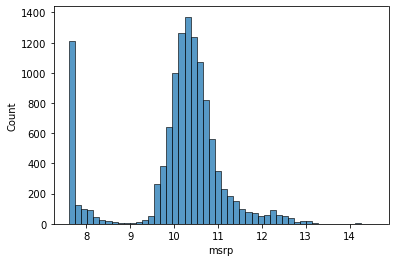

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

price_logs = np.log1p(df.msrp)
sns.histplot(
    price_logs, 
    bins=50
)

## Validation framework

In [118]:
# split dataset indexes into 60%-20%-20%
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

# shuffle index
idx = np.arange(n)
np.random.seed(2)
np.random.shuffle(idx)

# split dataset
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# save MSRP in natural logarithm form (1 + log)
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values) 
y_test = np.log1p(df_test.msrp.values)

# remove target column MSRP from dataset
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

## Linear Regression

In [107]:
def linear_regression(w, w0, xi):
    n = len(xi)
    pred = w0

    for j in range(n):
        pred = pred + w[j] * xi[j]

    return pred


# Example
xi = [453, 11, 86]
w0 = 7.17
w = [0.01, 0.04, 0.002]

res = linear_regression(w, w0, xi)

np.log1p(np.expm1(res))


12.312

## Linear Regression Vector Form

In [108]:
def dot(xi, w):
    n = len(xi)
    res = 0.0
    
    for j in range(n):
        res = res + xi[j] * w[j]
    
    return res

def linear_regression(w, w0, xi):
    xi = [1] + xi
    return dot(xi, [w0] + w)

# Example
xi = [453, 11, 86]
w0 = 7.17
w = [0.01, 0.04, 0.002]

linear_regression(w, w0, xi)

12.312

## Training a linear regression model

In [109]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

# Example
X = np.array([
    [148, 24, 1385],
    [132, 25, 2031],
    [453, 11, 86],
    [158, 24, 185],
    [172, 25, 201],
    [413, 11, 86],
    [38,  54, 185],
    [142, 25, 431],
    [453, 31, 86],
])
y = [10000, 20000, 15000, 20050, 10000, 20000, 15000, 25000, 12000]

train_linear_regression(X, y)

(25844.75405576679, array([ -16.08906468, -199.47254894,   -1.22802883]))

## Car price baseline model

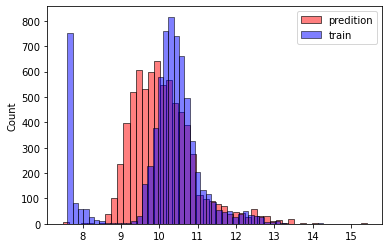

In [110]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

X_train = df_train[base].fillna(0).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

sns.histplot(y_pred, label="predition", color='red', alpha=0.5, bins=50)
sns.histplot(y_train, label="train", color='blue', alpha=0.5, bins=50)
plt.legend()

## RMSE

In [111]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

rmse(y_train, y_pred)

0.7554192603920132

## Validating the model

In [112]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

# train linear regression
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

# validation linear regression
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.7616530991301601

## Simple feature engineering

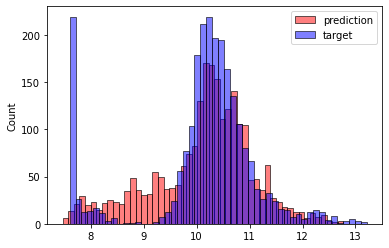

In [113]:
def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df['year']
    features = base + ['age']
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

## Categorical Variables

In [114]:
# non-number values include into training
categorical_columns = [
    'make', 'model', 'engine_fuel_type', 'driven_wheels', 'market_category',
    'vehicle_size', 'vehicle_style']

categorical = {}

for c in categorical_columns:
    categorical[c] = list(df_train[c].value_counts().head().index)

def prepare_X(df):
    df = df.copy()
    
    df['age'] = 2017 - df['year']
    features = base + ['age']

    for v in [2, 3, 4]:
        df['num_doors_%d' % v] = (df.number_of_doors == v).astype(int)
        features.append('num_doors_%d' % v)

    for name, values in categorical.items():
        for value in values:
            df['%s_%s' % (name, value)] = (df[name] == value).astype(int)
            features.append('%s_%s' % (name, value))

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X    

X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

25.276184146246752

## Regularization

In [115]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.46082082859947154

## Tuning the model

In [116]:
r = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score

0.46081585835984

## Using Model

In [123]:
# prepare train
df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)
X_full_train = prepare_X(df_full_train)
y_full_train = np.concatenate([y_train, y_val])

# run linear regression
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

# test and show scores
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
print("Score: {0}".format(score))

# Predict

car = df_test.iloc[20].to_dict()
df_small = pd.DataFrame([car])
X_small = prepare_X(df_small)
y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]


print("Predicted {0}; Test {1}".format(np.expm1(y_pred), np.expm1(y_test[20])))

Score: 0.46007539689045956
Predicted 41459.33676616719; Test 35000.00000000001
